In [11]:
from duplex_prob import filter_duplex_prob

sam_file = 'data/target_seqs/rosa26_against_full/rosa26.sam'
bed_file = 'data/target_seqs/rosa26_against_full/rosa26_probes.bed'

filter_duplex_prob(sam_file, bed_file, filter_temp=42, filter_prob=0.2)

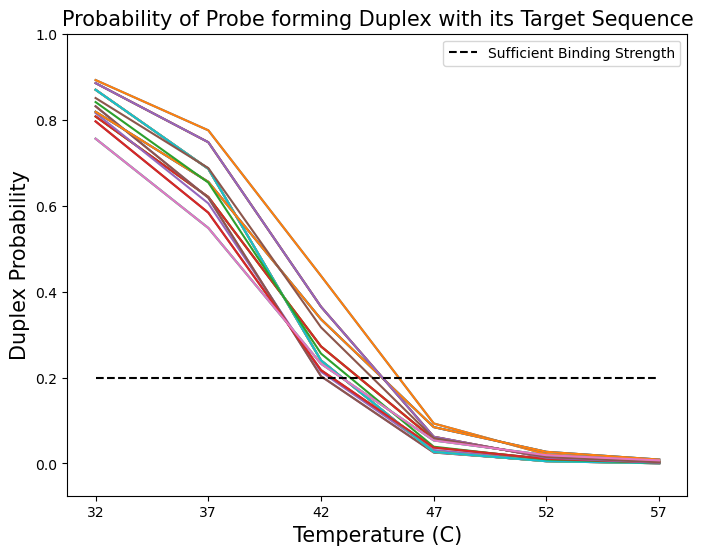

In [12]:
# PLOTTING RESULTS FROM duplex_prob.py #
from duplex_prob import plot_duplex_prob

filtered_filename = 'data/target_seqs/rosa26_against_full/rosa26_probes_filtered.bed'

###################################################################################################

plot_duplex_prob(filtered_filename)

In [57]:
import seqfold

def filter_secondary_structure(bed_filename, filter_MFE):
    '''
    Filters probes based on user-specified threshold for minimum free energy of secondary structures.
    Writes filtered probe sequences and minimum free energies to new .bed file.
        Arguments:
            - bed_filename [str] : relative path to .bed file containing sequences of probes
            - filter_MFE [float] : minimum free energy threshold; probes with MFE below this will be filtered out
                                  (probes with low MFEs have stable secondary structures and are less likely
                                   to form duplexes with target sequence)
    '''
    # collate original file lines #
    with open(bed_filename, 'r') as file:
        next(file)
        original_lines = [line.strip() for line in file]

    # collate probe sequences #
    with open(bed_filename, 'r') as file:
        next(file)
        seqs = [line.split('\t')[1].strip() for line in file]

    # calculate minimum free energy #
    MFEs = [seqfold.dg(seq) for seq in seqs]

    # filter by MFE #
    filtered_seqs_MFEs = []
    for seq, MFE in zip(seqs, MFEs):
        if MFE > filter_MFE:
            filtered_seqs_MFEs.append((seq, MFE))

    # for probes which passed filter, write sequences and MFEs to .bed file #
    output_filename = bed_filename.split('_filtered')[0] + '_pDup_MFE_filtered.bed'
    with open(output_filename, 'w') as file:
        # header line #
        file.write(
            f'{len(filtered_seqs_MFEs)} probes passed filtering with thresholds set to T=XXXC and PDup=XXX and MFE={filter_MFE} \n')
        # write as probe_number, probe_sequence, duplex_probabilities, MFE #
        for original_line, filtered_seq_MFE in zip(original_lines, filtered_seqs_MFEs):
            file.write(f'{original_line} \t {filtered_seq_MFE[1]} \n')



filter_secondary_structure(filtered_filename, 0.0)